
# OLMS — Tìm kiếm hình ảnh trong video (tối giản, có khử trùng pHash)

Pipeline gồm hai bước:
1) **Index**: lấy tối đa 3 video, cắt frames 1 fps, khử trùng bằng pHash, trích đặc trưng **VGG16-fc1 (4096-D)**, lưu `vectors.npy` và `meta.csv`.
2) **Search**: nhận một ảnh truy vấn, vector hoá ảnh, so cosine với chỉ mục, trả về **Top-K** khung hình và **timestamp**.



## Cấu trúc thư mục
```
./data/
  videos/
  frames/
  index/
  queries/
```


In [ ]:

# Tạo thư mục dữ liệu
import os
for d in ["data", "data/videos", "data/frames", "data/index", "data/queries"]:
    os.makedirs(d, exist_ok=True)
print("Created ./data folders.")


## Cài đặt thư viện (nếu thiếu)
TensorFlow/Keras (VGG16), OpenCV, Pillow, NumPy, Pandas, Matplotlib, ImageHash.


In [3]:
!pip install tensorflow opencv-python pillow numpy pandas matplotlib imagehash



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.2 MB 8.2 MB/s eta 0:00:01
   ------------------- -------------------- 2.1/4.2 MB 5.6 MB/s eta 0:00:01
   ----------------------------- ---------- 3.1/4.2 MB 5.1 MB/s eta 0:00:01
   ------------------------------------- -- 3.9/4.2 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 4.9 MB/s eta 0:00:00



## Tiện ích
- `format_hhmmss`: đổi giây sang HH:MM:SS.
- `print_tree`: in cây thư mục.


In [4]:

import os, time, glob, uuid
from typing import List, Tuple

def format_hhmmss(seconds: float) -> str:
    s = int(round(seconds))
    h = s // 3600
    m = (s % 3600) // 60
    sec = s % 60
    return f"{h:02d}:{m:02d}:{sec:02d}"

def print_tree(root="data", max_files_per_dir=5):
    for dirpath, dirnames, filenames in os.walk(root):
        depth = dirpath.count(os.sep) - root.count(os.sep)
        indent = "  " * depth
        base = os.path.basename(dirpath) or dirpath
        print(f"{indent}{base}/")
        shown = 0
        for f in sorted(filenames):
            print(f"{indent}  {f}")
            shown += 1
            if shown >= max_files_per_dir and len(filenames) > shown:
                print(f"{indent}  ... (+{len(filenames)-shown} files)")
                break

print_tree("data")

data/
  frames/
  index/
  queries/
  videos/
    CleanArch.mp4
    SignalR.mp4
    VGG16.mp4



## Cắt frame + khử trùng pHash


In [5]:

import cv2, numpy as np
from PIL import Image
import imagehash

def sample_frames_with_dedupe(video_path: str,
                              out_dir: str,
                              fps: int = 1,
                              phash_hamming_thresh: int = 8) -> List[Tuple[str, float]]:
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Không mở được video: {video_path}")

    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    step = max(int(round(orig_fps / fps)), 1)

    saved = []
    frame_idx = 0
    kept_idx = 0
    last_phash = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % step == 0:
            ts_s = frame_idx / orig_fps if orig_fps > 0 else 0.0
            pil_gray = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).convert("L")
            cur_phash = imagehash.phash(pil_gray)

            duplicate = False
            if last_phash is not None and (last_phash - cur_phash) <= phash_hamming_thresh:
                duplicate = True

            if not duplicate:
                out_path = os.path.join(out_dir, f"frame_{kept_idx:06d}.jpg")
                cv2.imwrite(out_path, frame)
                saved.append((out_path, ts_s))
                kept_idx += 1
                last_phash = cur_phash

        frame_idx += 1

    cap.release()
    return saved


## VGG16 (fc1, 4096-D) + L2 normalize


In [6]:

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

_vgg_base = VGG16(weights="imagenet")
VGG_FC1 = Model(inputs=_vgg_base.input, outputs=_vgg_base.get_layer("fc1").output)

def vgg16_embed_bgr(bgr_img: np.ndarray) -> np.ndarray:
    img = cv2.cvtColor(cv2.resize(bgr_img, (224, 224)), cv2.COLOR_BGR2RGB).astype(np.float32)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    vec = VGG_FC1(x, training=False).numpy()[0].astype(np.float32)  # (4096,)
    n = np.linalg.norm(vec) + 1e-8
    return (vec / n).astype(np.float32)

def vgg16_embed_path(img_path: str) -> np.ndarray:
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise RuntimeError(f"Không đọc được ảnh: {img_path}")
    return vgg16_embed_bgr(bgr)


## Index 3 video


In [7]:

import pandas as pd
import numpy as np

video_dir = "data/videos"
videos = sorted([os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.lower().endswith(".mp4")])[:3]
print("Videos:", *videos, sep="\n- ")

all_vecs = []
meta_rows = []

for v in videos:
    media_id = str(uuid.uuid4())
    frames_dir = os.path.join("data/frames", media_id)
    print(f"\n>>> Processing: {v}\nmedia_id: {media_id}")
    t0 = time.time()
    frames = sample_frames_with_dedupe(v, frames_dir, fps=1, phash_hamming_thresh=8)
    print(f"- kept frames: {len(frames)} (after dedupe)")

    for fpath, ts in frames:
        bgr = cv2.imread(fpath)
        feat = vgg16_embed_bgr(bgr)  # (4096,)
        all_vecs.append(feat)
        meta_rows.append({
            "media_id": media_id,
            "video_path": os.path.abspath(v),
            "frame_path": os.path.abspath(fpath),
            "timestamp_s": float(ts),
            "hhmmss": format_hhmmss(ts)
        })

    print(f"- time for this video: {time.time()-t0:.2f} s")

os.makedirs("data/index", exist_ok=True)
if len(all_vecs) > 0:
    vecs = np.stack(all_vecs, axis=0).astype(np.float32)  # (N,4096)
    np.save("data/index/vectors.npy", vecs)
    pd.DataFrame(meta_rows).to_csv("data/index/meta.csv", index=False)
    print(f"Saved: data/index/vectors.npy shape={vecs.shape}")
    print(f"Saved: data/index/meta.csv rows={len(meta_rows)}")
else:
    print("No frames extracted; check input videos.")

Videos:
- data/videos\CleanArch.mp4
- data/videos\SignalR.mp4
- data/videos\VGG16.mp4

>>> Processing: data/videos\CleanArch.mp4
media_id: 40e12b0d-522a-4be7-b8d4-f75f7db129a0
- kept frames: 18 (after dedupe)
- time for this video: 38.00 s

>>> Processing: data/videos\SignalR.mp4
media_id: d6333339-216a-4ec4-8605-d35125ada7f7
- kept frames: 26 (after dedupe)
- time for this video: 34.74 s

>>> Processing: data/videos\VGG16.mp4
media_id: c134193a-f944-4987-989b-9ded5c47e720
- kept frames: 31 (after dedupe)
- time for this video: 45.34 s
Saved: data/index/vectors.npy shape=(75, 4096)
Saved: data/index/meta.csv rows=75



## Search bằng ảnh truy vấn


Query image: data/queries\image.png
Query time: 526.35 ms (Top-5)
#1 score=0.9196 time=00:00:21 video=SignalR.mp4
   frame: d:\Projects\Basic_Project_CSharp\Online_Management_System - Copy\API\AI\data\frames\d6333339-216a-4ec4-8605-d35125ada7f7\frame_000012.jpg
#2 score=0.8709 time=00:00:23 video=SignalR.mp4
   frame: d:\Projects\Basic_Project_CSharp\Online_Management_System - Copy\API\AI\data\frames\d6333339-216a-4ec4-8605-d35125ada7f7\frame_000014.jpg
#3 score=0.8627 time=00:00:22 video=SignalR.mp4
   frame: d:\Projects\Basic_Project_CSharp\Online_Management_System - Copy\API\AI\data\frames\d6333339-216a-4ec4-8605-d35125ada7f7\frame_000013.jpg
#4 score=0.8542 time=00:00:24 video=SignalR.mp4
   frame: d:\Projects\Basic_Project_CSharp\Online_Management_System - Copy\API\AI\data\frames\d6333339-216a-4ec4-8605-d35125ada7f7\frame_000015.jpg
#5 score=0.8479 time=00:00:36 video=SignalR.mp4
   frame: d:\Projects\Basic_Project_CSharp\Online_Management_System - Copy\API\AI\data\frames\d6333339

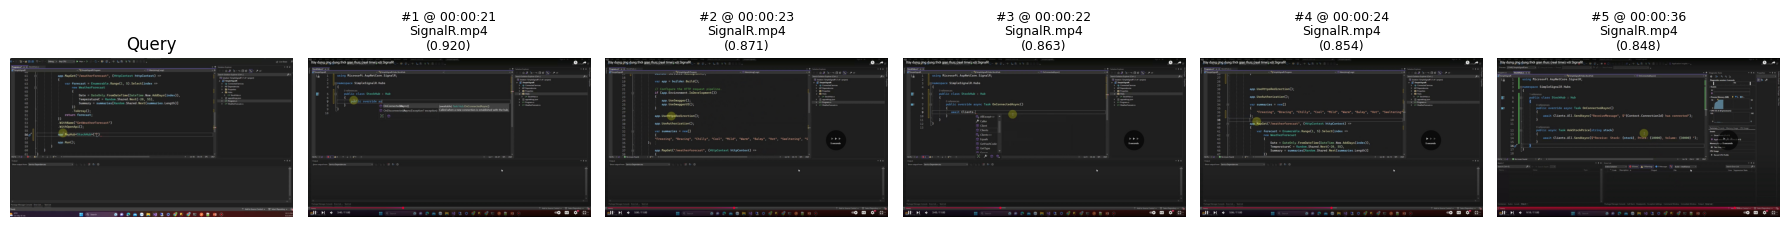

In [12]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image

query_dir = "data/queries"
query_images = sorted([os.path.join(query_dir, f) for f in os.listdir(query_dir) if f.lower().endswith((".jpg",".jpeg",".png"))])
if not query_images:
    raise SystemExit("Chưa có ảnh truy vấn trong ./data/queries/.")

query_path = query_images[0]
print("Query image:", query_path)

vecs = np.load("data/index/vectors.npy")
meta = pd.read_csv("data/index/meta.csv")

def search_top_k(query_img_path: str, K: int = 5):
    q = vgg16_embed_path(query_img_path)
    sims = vecs @ q
    ids = np.argsort(-sims)[:K]
    results = []
    for rank, idx in enumerate(ids, start=1):
        row = meta.iloc[idx].to_dict()
        results.append({
            "rank": rank,
            "score": float(sims[idx]),
            "media_id": row["media_id"],
            "video_path": row["video_path"],
            "frame_path": row["frame_path"],
            "timestamp_s": float(row["timestamp_s"]),
            "hhmmss": row["hhmmss"]
        })
    return results

K = 5
t0 = time.time()
res = search_top_k(query_path, K=K)
dt_ms = (time.time() - t0) * 1000
print(f"Query time: {dt_ms:.2f} ms (Top-{K})")
for r in res:
    print(f"#{r['rank']} score={r['score']:.4f} time={r['hhmmss']} video={os.path.basename(r['video_path'])}")
    print(f"   frame: {r['frame_path']}")

cols = K + 1
plt.figure(figsize=(3*cols, 4))
plt.subplot(1, cols, 1)
plt.imshow(Image.open(query_path)); plt.axis("off"); plt.title("Query")
for i, r in enumerate(res, start=2):
    plt.subplot(1, cols, i)
    plt.imshow(Image.open(r["frame_path"])); plt.axis("off")
    plt.title(f"#{r['rank']} @ {r['hhmmss']}\n{os.path.basename(r['video_path'])}\n({r['score']:.3f})", fontsize=9)
plt.tight_layout()
plt.show()